In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("e11.csv")

#Data Preprocessing - By visualizing the raw data we identified coulumns with too many missing values (either NaN or #REF or #NA), at least more than half, and drop those columns. There columns are c189, c190, c199, c202, c204, c206, c207 - c223, c231, c232, c233, c234, c226

# Data Preprocessing

In [5]:
columns_to_drop = ['c1', 'c188', 'c189', 'c190', 'c199', 'c202', 'c204', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216',
                   'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c231', 'c232', 'c233', 'c234', 'c226', 'c229']

df = df.drop(columns=columns_to_drop)

Next we take care of the cells which have some non numeric values like and convert them all to numeric so that they appear similar as missing values, so that its eaier to impute later.

In [6]:
df1 = df.apply(pd.to_numeric,errors='coerce')


**Imputing NaN values using mean**

In [7]:
df1 = df1.fillna(df1.mean())

In [8]:
df1.to_csv('df1.csv')

In [9]:
!pip install plotly

In [10]:
import plotly.express as px

In [11]:
!pip install nbformat

**Using plotly to generate interactive box plots for all variables to visualise outliers**

In [12]:
import warnings
warnings.filterwarnings("ignore")

fig = px.box(df1)
fig.update_layout(height=600, width=1200)
fig.show()

**Visualising outliers for all variables using histogram**

In [13]:
columns = df1.columns

# We created histograms for each column using a loop
'''for column in columns:
    histogram = px.histogram(df1, x=column, title=f'Histogram for {column}')
    histogram.show()'''
#But we are showing for some example of constant and non-constant columns
#only to not make this file full of histogram images
example_columns = ['c159','c169', 'c165']
for column in example_columns:
    histogram = px.histogram(df1, x=column, title=f'Histogram for {column}')
    histogram.show()

**After reviewing the histograms, we see there are few more vairables which need to be dropped as they have the same value across all observations and will not have any effect on model output. Note: None of these columns fall in the ambit of controllable parameters that is: c26, c27, c28, c29, c30, c31, c32,
c33, c39, c139, c142, c143, c155, c156, c157, c158, c160, c161, c162, c163**

In [14]:
constant_columns = ['c2', 'c82','c110',	'c168',	'c169',	'c170',	'c171']

df1 = df1.drop(columns=constant_columns)

**Defining and replacing outliers**

In [15]:
def replace_outliers_with_mean(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Replace outliers with the median value
    column = column.apply(lambda x: column.mean() if x < lower_bound or x > upper_bound else x)
    return column

# Iterate through each column in the DataFrame
for column in df1.columns:
    # Exclude target columns from outlier replacement
    if column not in ['c51', 'c52', 'c53', 'c54', 'c241']:
        # Replace outliers with the median value for each column
        df1[column] = replace_outliers_with_mean(df1[column])

**Heat Map for visualizing correlations between variabels**

In [16]:

correlation_matrix = df1.corr()

# Create a heatmap using Plotly Express
fig = px.imshow(correlation_matrix,
                labels=dict(x="Features", y="Features", color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale="Viridis")

# Customize the layout
fig.update_layout(title="Correlation Heatmap",
                  xaxis=dict(tickangle=-45),
                  yaxis=dict(tickangle=45),
                  width=800, height=600)

# Show the plot
fig.show()

**Now we check for multicolinearity using VIF**

In [17]:
!pip install statsmodels

VIF Results:
    Variable           VIF
0         c3  1.880863e+02
1         c4  4.832191e+07
2         c5  7.631894e+09
3         c6  3.392274e+10
4         c7  6.919080e+00
..       ...           ...
197     c236  1.008486e+02
198     c237  2.937035e+02
199     c238  5.514066e+00
200     c239  7.109210e+00
201     c241  5.449953e+00

[202 rows x 2 columns]


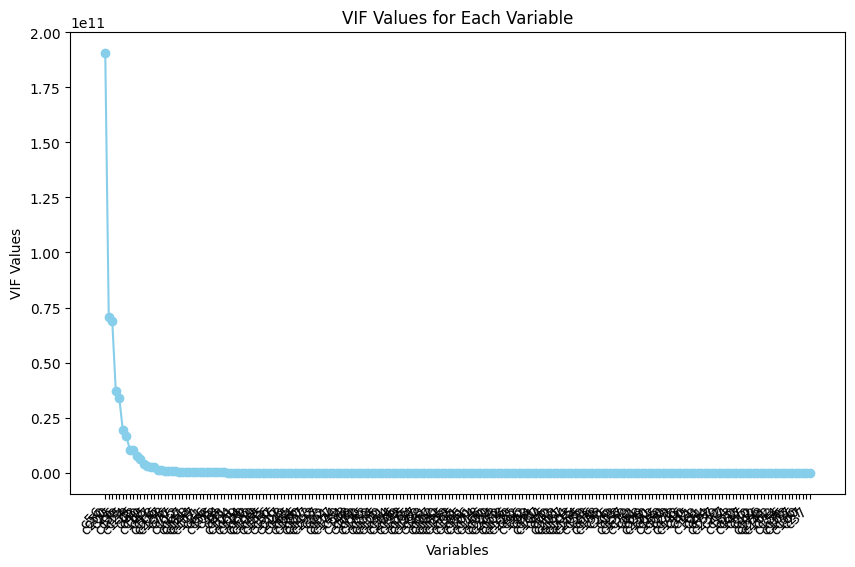


DataFrame df2 with High VIF Features Dropped:
            c7         c8       c10        c11        c12       c14       c20  \
0     2.264965  18.978886  0.719497  58.340911  10.824996  0.002228  7.120964   
1     2.260011  20.188791  0.702348  58.340911  10.824996  0.002228  7.793413   
2     2.085850  20.188791  0.656799  58.340911  10.824996  0.002228  7.289157   
3     2.258069  20.188791  0.662394  58.340911   9.744850  0.011701  7.958076   
4     2.252392  20.188791  0.689549  56.226017  10.457647  0.011701  8.757605   
...        ...        ...       ...        ...        ...       ...       ...   
1020  2.150980  19.448113  0.577761  57.962816  11.216774  0.002229  7.606814   
1021  2.145125  19.449504  0.585410  57.752414  11.321437  0.002229  8.093012   
1022  2.149443  19.411187  0.586067  57.625140  11.288059  0.002229  7.956216   
1023  2.144927  19.426058  0.583313  57.386525  11.327831  0.002229  7.985720   
1024  2.144609  19.457788  0.587881  57.289982  11.310388  0.0

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df1 is your original DataFrame
# Define controllable_and_target_parameters
controllable_and_target_parameters = ['c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32',
                                       'c33', 'c39', 'c139', 'c142', 'c143', 'c155', 'c156',
                                       'c157', 'c158', 'c160', 'c161', 'c162', 'c163', 'c51',
                                       'c52', 'c53', 'c54', 'c241']

# Calculate VIF for each variable in df1
vif_data = pd.DataFrame()
vif_data["Variable"] = df1.columns
vif_data["VIF"] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]

# Display the VIF values
print("VIF Results:")
print(vif_data)

# Sort VIF values
vif_results_sorted = vif_data.sort_values(by='VIF', ascending=False)

# Plot the VIF values
plt.figure(figsize=(10, 6))
plt.plot(vif_results_sorted['Variable'], vif_results_sorted['VIF'], marker='o', linestyle='-', color='skyblue')
plt.xlabel('Variables')
plt.ylabel('VIF Values')
plt.title('VIF Values for Each Variable')
plt.xticks(rotation=45, ha='right')
plt.show()

# Set a threshold for high VIF
high_vif_threshold = 10
high_vif_features = vif_data[vif_data['VIF'] > high_vif_threshold]['Variable']

# Drop features with high VIF that are not in controllable_and_target_parameters
high_vif_features_filtered = high_vif_features[~high_vif_features.isin(controllable_and_target_parameters)]

# Create a new DataFrame df2 by dropping features with high VIF
df2 = df1.drop(columns=high_vif_features_filtered)

# Display the new DataFrame df2
print("\nDataFrame df2 with High VIF Features Dropped:")
print(df2)


In [19]:
print("Features with High VIF:")
print(high_vif_features.tolist())

Features with High VIF:
['c3', 'c4', 'c5', 'c6', 'c9', 'c13', 'c15', 'c16', 'c17', 'c18', 'c19', 'c23', 'c24', 'c25', 'c26', 'c28', 'c29', 'c31', 'c32', 'c33', 'c38', 'c39', 'c40', 'c41', 'c43', 'c46', 'c47', 'c48', 'c49', 'c50', 'c51', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c64', 'c65', 'c66', 'c67', 'c68', 'c69', 'c70', 'c71', 'c74', 'c75', 'c76', 'c77', 'c78', 'c79', 'c80', 'c81', 'c83', 'c84', 'c86', 'c87', 'c88', 'c89', 'c90', 'c91', 'c92', 'c93', 'c94', 'c95', 'c96', 'c97', 'c98', 'c99', 'c100', 'c101', 'c102', 'c103', 'c104', 'c105', 'c106', 'c107', 'c108', 'c109', 'c111', 'c112', 'c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c134', 'c135', 'c136', 'c138', 'c139', 'c140', 'c141', 'c142', 'c143', 'c144', 'c145', 'c148', 'c149', 'c125', 'c126', 'c127', 'c128', 'c129', 'c130', 'c131', 'c132', 'c150', 'c151', 'c152', 'c153', 'c154', 'c155', 'c157', 'c158', 'c159', 'c164', 'c165', 'c166', 'c167'

**Next we convert the 4 target variables to categorical - We use feature binning as a method and tranform these variables**

**Creating New variable 'overall_risk' which takes categorical values of SAFE, MODERATE, HIGH and CRITICAL depending on values in c51 to c54. For example if any value in all four columns is above 20 that data point will take value 'CRITICAL' in the overall risk column.**

In [20]:
import pandas as pd


# Create the 'overall_risk' column based on the maximum value across the target columns
df2['overall_risk'] = df2[['c51', 'c52', 'c53', 'c54']].max(axis=1)

# Map numerical values to risk categories
df2['overall_risk'] = pd.cut(df2['overall_risk'], bins=[-float('inf'), 5, 10, 20, float('inf')],
                             labels=['SAFE', 'MODERATE', 'HIGH', 'CRITICAL'], right=False)

# Print unique values for the 'overall_risk' column
unique_values = df2['overall_risk'].unique()
print(f"Unique values for overall_risk: {unique_values}")

Unique values for overall_risk: ['MODERATE', 'HIGH', 'CRITICAL']
Categories (4, object): ['SAFE' < 'MODERATE' < 'HIGH' < 'CRITICAL']


**Label encoding Target Variable 'overall_risk' with class mapping**

In [21]:
from sklearn.preprocessing import LabelEncoder
selected_columns = ['overall_risk']

# Initialize the LabelEncoder for each selected column
label_encoders = {}
for column in selected_columns:
    label_encoders[column] = LabelEncoder()
    df1[column] = label_encoders[column].fit_transform(df2[column])

**Importing necessary libraries**

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

# Task 1: Implementing ML to predict when vibrations reach 'High' or 'Critical' Values

**Creating X and y, label encoding y, splitting data into train and test**

In [23]:

X_initial = df1.drop(['c51', 'c52', 'c53', 'c54', 'overall_risk'], axis=1)
y = df2['overall_risk']

# Split the data into training and testing sets for the initial model
X_train_initial, X_test_initial, y_train, y_test = train_test_split(X_initial, y, test_size=0.2, stratify = y, random_state=42)

**Since the data has many variables acorss various ranges we will normalize the data using Min-Max Scaling**

In [24]:
scaler = MinMaxScaler()
X_train_initial_scaled = scaler.fit_transform(X_train_initial)
X_test_initial_scaled = scaler.transform(X_test_initial)

**We then train our data on a simple Random Forest Classifier before dropping any features which may have multicolinearity.**

In [108]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, classification_report

lr = LogisticRegression(max_iter=1000, solver='liblinear')

lr.fit(X_train_initial, y_train)

# Initial model evaluation
y_pred_initial_lr = lr.predict(X_test_initial)
accuracy_initial = accuracy_score(y_test, y_pred_initial_lr)
recall = recall_score(y_test, y_pred_initial_lr, average='macro')   
print(f"Initial Model Accuracy: {accuracy_initial}")
print(f"Macro Average Recall: {recall}")
# Confusion matrix
conf_matrix_initial_lr = confusion_matrix(y_test, y_pred_initial_lr)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_initial_lr)

# Print classification report for additional metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_initial_lr))


Initial Model Accuracy: 0.9170731707317074
Macro Average Recall: 0.9067537860283341
Confusion Matrix:
[[21  3  0]
 [ 2 82  5]
 [ 0  7 85]]
Classification Report:
              precision    recall  f1-score   support

    CRITICAL       0.91      0.88      0.89        24
        HIGH       0.89      0.92      0.91        89
    MODERATE       0.94      0.92      0.93        92

    accuracy                           0.92       205
   macro avg       0.92      0.91      0.91       205
weighted avg       0.92      0.92      0.92       205



**Retraining mlr model with limited features using df2 which has no feature with high vif**

In [109]:
X_filtered = df2.drop(['c51', 'c52', 'c53', 'c54', 'overall_risk'], axis=1)

# Split the data into training and testing sets for the initial model
X_train_filtered, X_test_filtered = train_test_split(X_filtered, test_size=0.2, random_state=42, stratify = y)

scaler = MinMaxScaler()
X_train_filtered_scaled = scaler.fit_transform(X_train_filtered)
X_test_filtered_scaled = scaler.transform(X_test_filtered)

lr.fit(X_train_filtered, y_train)

# Initial model evaluation
y_pred_filtered_lr = lr.predict(X_test_filtered)
accuracy_filtered = accuracy_score(y_test, y_pred_filtered_lr)
recall_filtered = recall_score(y_test, y_pred_filtered_lr, average='macro')
print(f"New Model Accuracy: {accuracy_filtered}")
print(f"Macro Average Recall: {recall_filtered}")

# Confusion matrix
conf_matrix_filtered_lr = confusion_matrix(y_test, y_pred_filtered_lr)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_filtered_lr)

# Print classification report for additional metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_filtered_lr))


New Model Accuracy: 0.926829268292683
Macro Average Recall: 0.9341651739673233
Confusion Matrix:
[[23  1  0]
 [ 0 79 10]
 [ 0  4 88]]
Classification Report:
              precision    recall  f1-score   support

    CRITICAL       1.00      0.96      0.98        24
        HIGH       0.94      0.89      0.91        89
    MODERATE       0.90      0.96      0.93        92

    accuracy                           0.93       205
   macro avg       0.95      0.93      0.94       205
weighted avg       0.93      0.93      0.93       205



**Alternative Method: There are some machine learnign models which take care of the multicolinearity of the features by using certain methods like regularization and can give good results with the right hyper parameter tuning even without identifying things like VIF. We demonstrate the use of one such ML model which Support Vector Classifier**

In [112]:
from sklearn.svm import SVC
param_grid = {
    'C': [0.001, 0.01, 0.1],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
}


# Create an SVM classifier
svm = SVC()


# Define the number of folds
num_folds = 10

# Create a cross-validation object (KFold)
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Create a GridSearchCV object with the SVM model and parameter grid
grid_search = GridSearchCV(svm, param_grid, cv=kf, scoring='recall_macro', n_jobs=-1)

# Fit the GridSearchCV object on your data
grid_search.fit(X_train_initial_scaled, y_train)

# Print the best parameters and the corresponding mean cross-validated score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Get the best parameters and the corresponding accuracy
best_params = grid_search.best_params_
best_recall = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Recall:", best_recall)

# Evaluate the model on the test data using the best parameters
best_svm= grid_search.best_estimator_
y_pred_svm = best_svm.predict(X_test_initial_scaled)
test_recall_svm = recall_score(y_test, y_pred_svm, average='macro')
print("Test Macro Average Recall SVM:", test_recall_svm)

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Best Score: 0.9667476422080437
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Best Recall: 0.9667476422080437
Test Macro Average Recall SVM: 0.953013895673886


In [113]:
from sklearn.metrics import confusion_matrix

y_pred_svm = best_svm.predict(X_test_initial_scaled)

# Confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Print the confusion matrix
print("Confusion Matrix SVM:")
print(conf_matrix_svm)

# Print classification report for additional metrics
print("Classification Report SVM:")
print(classification_report(y_test, y_pred_svm))

Confusion Matrix SVM:
[[23  1  0]
 [ 0 85  4]
 [ 0  5 87]]
Classification Report SVM:
              precision    recall  f1-score   support

    CRITICAL       1.00      0.96      0.98        24
        HIGH       0.93      0.96      0.94        89
    MODERATE       0.96      0.95      0.95        92

    accuracy                           0.95       205
   macro avg       0.96      0.95      0.96       205
weighted avg       0.95      0.95      0.95       205



**As we can see SVM beats the metrics of the base model we used which is logistic regression. We also go on to plot the learnign curves for SVM**

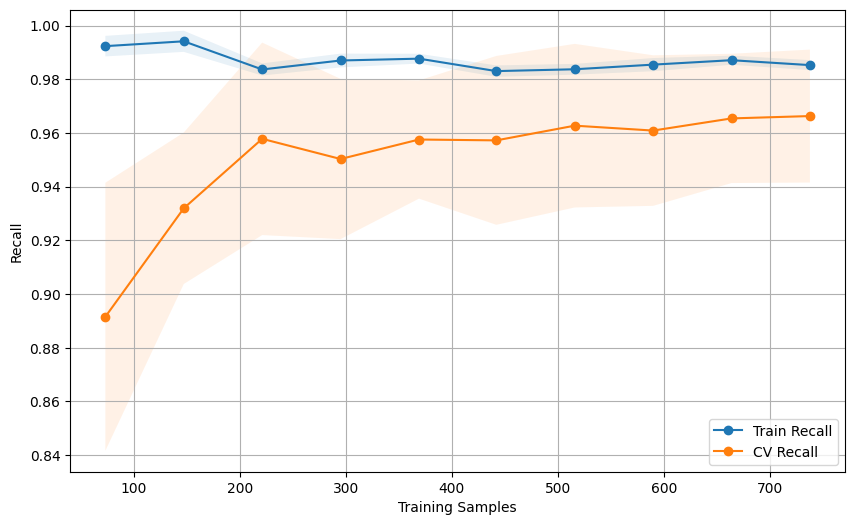

In [114]:
from sklearn.model_selection import learning_curve, StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    best_svm,
    X_train_initial_scaled,
    y_train,
    cv=cv,
    scoring='recall_macro',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean  = test_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
test_std   = test_scores.std(axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', label='Train Recall')
plt.plot(train_sizes, test_mean, 'o-', label='CV Recall')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.1)
plt.xlabel('Training Samples')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.show()


Next task is to create ML models to predict and control these vibrations using only the 'controllable parameters'. It is proposed to create an automated
vibration control and reduction system that gets activated when the vibrationsnreach high and critical levels. One of the goals of this model should be to create
a list of the most important parameters to change to reduce vibrations. This list should be in descending order of importance.
This can be done by **two approaches**, in the **first we will use a ML model which gives us inbuilt feature importance such as Radnom Forest**.
In the second method we use a **model agnostic method - SHapeley Additive exPlanations (SHAP values) as a method to identify class wise feature importance**.

In [30]:
controllable_parameters = ['c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32',
'c33', 'c39', 'c139', 'c142', 'c143', 'c155', 'c156', 'c157', 'c158', 'c160', 'c161', 'c162', 'c163']

Accuracy RF: 0.9463414634146341
Macro Average Recall RF: 0.9596564077511806
Classification Report RF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.92      0.96      0.94        89
           2       0.96      0.92      0.94        92

    accuracy                           0.95       205
   macro avg       0.96      0.96      0.96       205
weighted avg       0.95      0.95      0.95       205



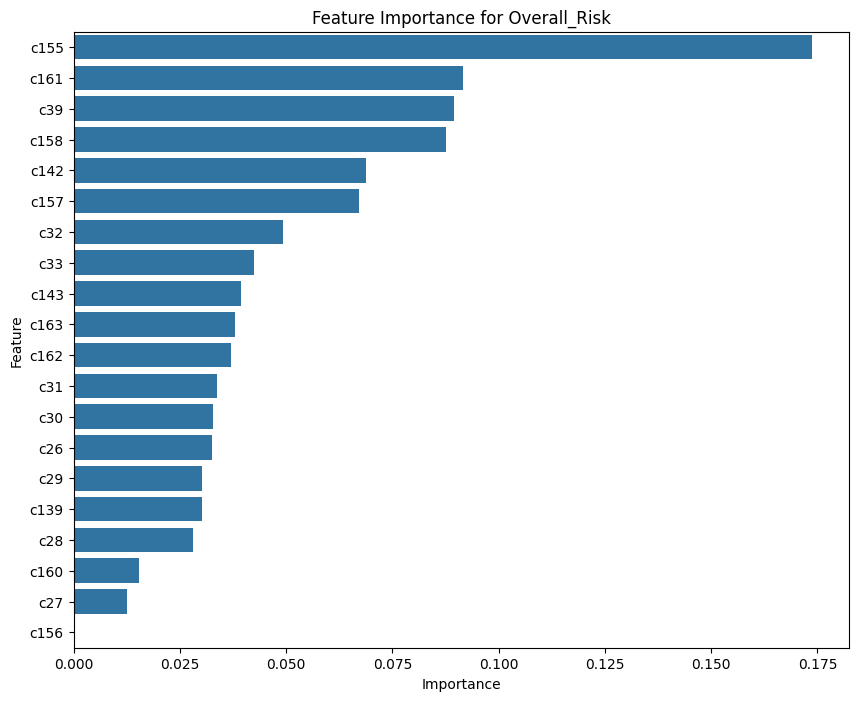

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

controllable_parameters = ['c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c39', 'c139', 'c142', 'c143', 'c155', 'c156', 'c157', 'c158', 'c160', 'c161', 'c162', 'c163']
X_controllable = df1[controllable_parameters]
y = df1['overall_risk']

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_controllable, y, test_size=0.2, stratify=y, random_state=42)

X_train_rf_scaled = scaler.fit_transform(X_train_rf)
X_test_rf_scaled = scaler.transform(X_test_rf)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_rf_scaled, y_train_rf)

# Predictions on the test set
y_pred_rf = rf_classifier.predict(X_test_rf_scaled)

# Evaluate the model
print("Accuracy RF:", accuracy_score(y_test_rf, y_pred_rf))
recall_rf = recall_score(y_test_rf, y_pred_rf, average='macro')
print(f"Macro Average Recall RF: {recall_rf}")
print("Classification Report RF:")
print(classification_report(y_test_rf, y_pred_rf))

# Feature importance
feature_importance = rf_classifier.feature_importances_

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({'Feature': controllable_parameters, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Overall_Risk')
plt.show()


In [50]:
feature_importance_df.to_csv('feature_importance_vibrations.csv')

In [33]:
!pip install shap

**Implementing SHAP**

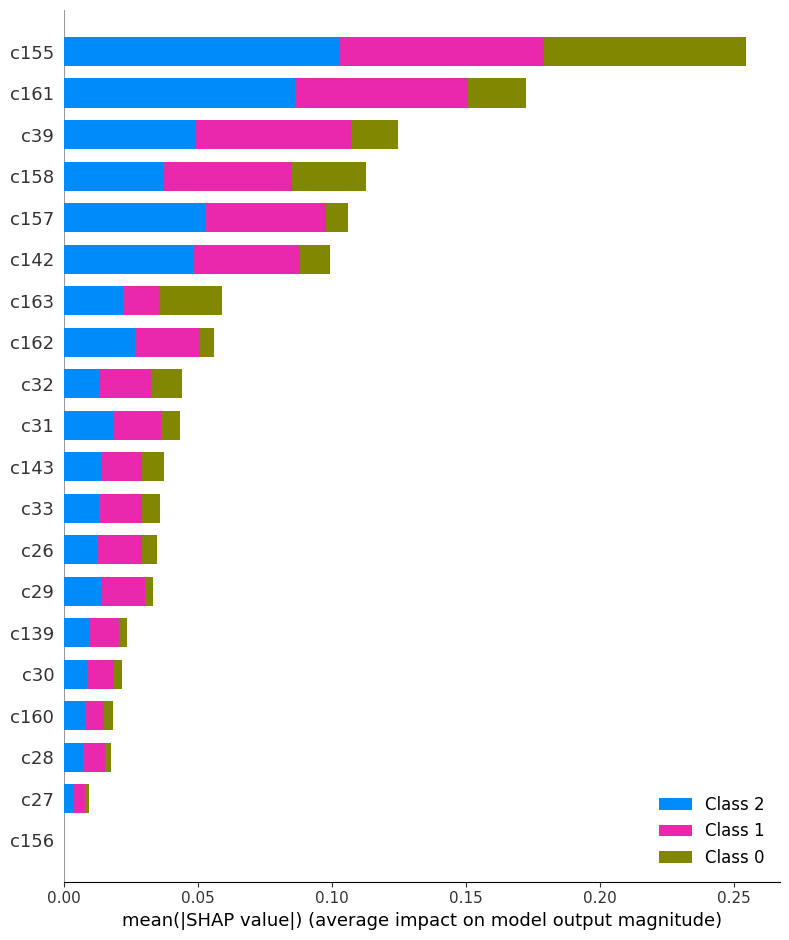

In [34]:
import shap
explainer = shap.TreeExplainer(rf_classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_rf_scaled)

# Plot the summary plot
shap.summary_plot(shap_values, X_test_rf_scaled, feature_names=controllable_parameters, plot_type='bar')

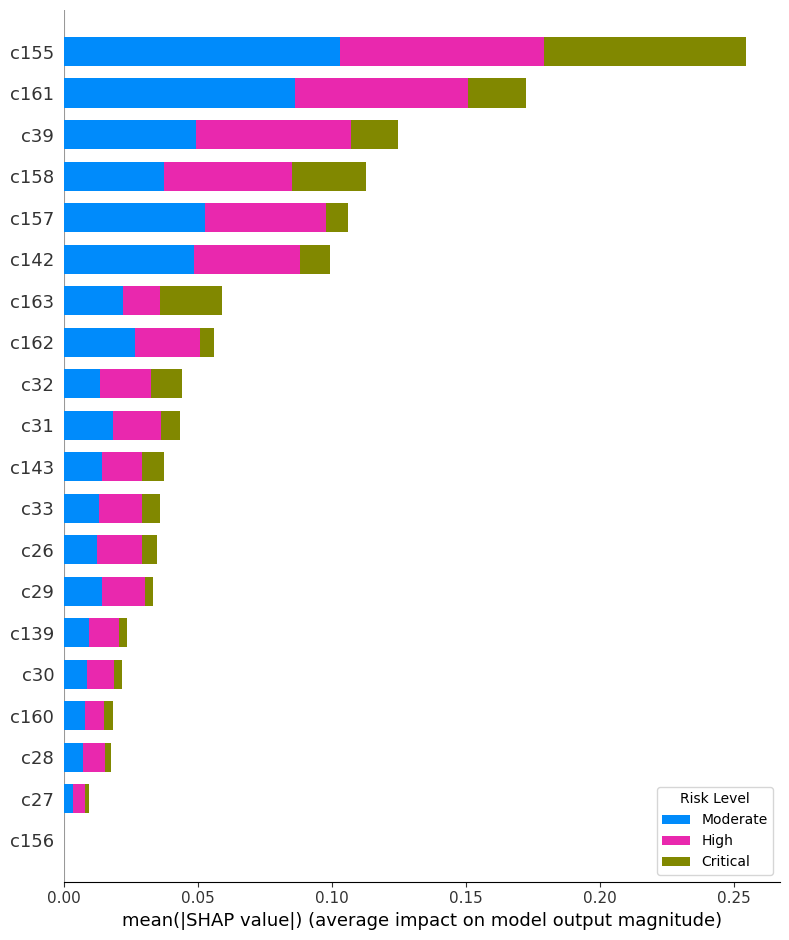

In [52]:
import matplotlib.pyplot as plt

shap.summary_plot(
    shap_values,
    X_test_rf_scaled,
    feature_names=controllable_parameters,
    plot_type="bar",
    show=False  # IMPORTANT
)

# Get current legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

class_names = {
    "Class 0": "Critical",
    "Class 1": "High",
    "Class 2": "Moderate"
}


# Replace labels
new_labels = [class_names.get(label, label) for label in labels]

ax.legend(handles, new_labels, title="Risk Level")

plt.show()


In [74]:
shap_values.T.shape

(3, 20, 205)

In [73]:
len(shap_values.T)

3

In [87]:
feature_names = controllable_parameters  

importance_per_class = {}

for class_idx, sv in enumerate(shap_values.T):
    importance_per_class[f"Class_{class_idx}"] = np.mean(
        np.abs(sv.T), axis=0
    )


In [88]:
importance_df = pd.DataFrame(
    importance_per_class,
    index=feature_names
)

importance_df["Total_Importance"] = importance_df.sum(axis=1)

# Sort by total importance
importance_df = importance_df.sort_values(
    by="Total_Importance", ascending=False
)


In [93]:
importance_df.rename(columns={
    "Class_0": "Critical",
    "Class_1": "High",
    "Class_2": "Moderate"
}, inplace=True)  

In [94]:
importance_df

Critical      High  Moderate  Total_Importance
c155  0.075388  0.076194  0.102902          0.254484
c161  0.021670  0.064624  0.086060          0.172355
c39   0.017752  0.057678  0.049398          0.124829
c158  0.027712  0.047838  0.037160          0.112710
c157  0.008063  0.045438  0.052503          0.106004
c142  0.011179  0.039779  0.048439          0.099397
c163  0.023270  0.013820  0.021860          0.058950
c162  0.005188  0.024060  0.026627          0.055875
c32   0.011762  0.019019  0.013406          0.044187
c31   0.006865  0.017874  0.018432          0.043172
c143  0.008342  0.014924  0.014093          0.037359
c33   0.006695  0.015895  0.013192          0.035782
c26   0.005512  0.016714  0.012309          0.034535
c29   0.002969  0.015885  0.014218          0.033072
c139  0.002958  0.010963  0.009470          0.023392
c30   0.002729  0.010316  0.008496          0.021542
c160  0.003474  0.007102  0.007822          0.018399
c28   0.002082  0.008223  0.007238          0.017543
c27   0.001600  0.004358  0.003485          0.009443
c156  0.000000  0.000000  0.000000          0.000000

In [95]:
importance_df.to_csv('shap_feature_importance_for_vibrations.csv')

# Task 2: C241 as Target Variable

In [35]:
columns_to_drop = ['c241', 'overall_risk']
X_c241 = df2.drop(columns=columns_to_drop)


#Matrics of depenent variable
y_c241 = df2['c241']

# Task 2, part 1: ML prediction model to understand which parameters (operating + controllable) significantly contribute to the ‘specific energy’

In [36]:
X_c241_normalized = scaler.fit_transform(X_c241)

# Convert the result back to a DataFrame (optional)
X_c241_normalized_df = pd.DataFrame(X_c241_normalized, columns=X_c241.columns)

**Implementing mlr model**

In [40]:
import statsmodels.api as sm
X_var_c241 = sm.add_constant(X_c241_normalized_df)

In [43]:
mlr_model = sm.OLS(y_c241,X_var_c241).fit()

In [96]:
mlr_model_summary = mlr_model.summary()
print(mlr_model_summary)

                            OLS Regression Results                            
Dep. Variable:                   c241   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     6.494
Date:                Wed, 28 Jan 2026   Prob (F-statistic):           4.70e-36
Time:                        19:18:59   Log-Likelihood:                -981.61
No. Observations:                1025   AIC:                             2069.
Df Residuals:                     972   BIC:                             2331.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0180      0.487      8.242      0.0

In [120]:
# sort the features on the basis of absolute value of their coefficients
df_coeff = pd.DataFrame(mlr_model.params, columns=['Coefficient'])
imp_order = pd.DataFrame(df_coeff['Coefficient'].abs().sort_values(ascending=False))
imp_order.rename(columns={'Coefficient': 'Absolute Coefficient'}, inplace=True)
imp_order

Absolute Coefficient
const              4.017975
c155               2.072155
c39                1.365522
c139               1.036667
c26                0.957030
c32                0.913201
c22                0.801206
c143               0.799545
c137               0.681686
c72                0.601606
c158               0.591338
c7                 0.558739
c42                0.551763
c53                0.542555
c157               0.516179
c20                0.509314
c21                0.500713
c28                0.401853
c33                0.393902
c73                0.392365
c31                0.372002
c147               0.348229
c29                0.310202
c85                0.305636
c45                0.303773
c133               0.273627
c35                0.259827
c160               0.258501
c12                0.250150
c14                0.205059
c34                0.204746
c239               0.199518
c27                0.197264
c30                0.193622
c142               0.192567
c51                0.157211
c163               0.144724
c54                0.143759
c44                0.125531
c36                0.123357
c11                0.120291
c238               0.109711
c10                0.107097
c176               0.077104
c177               0.071722
c8                 0.071115
c161               0.066375
c37                0.044692
c63                0.031363
c162               0.019431
c156               0.017811
c52                0.014177
c146               0.004037

In [121]:
imp_order.to_csv('Feature_importance_order_to_reduce_vibration.csv')

# Task 2, part 2: find out the minimum number of ‘independent’ variables that can be used to ‘only predict – not control’ the specific energy consumption

**Attempt 1 - Use PCA** We decided to use PCA on the original dataset which ha features with High VIF also as PCA itself will take care of any multicolinearity

Number of components to explain 90.0% of the variance: 28


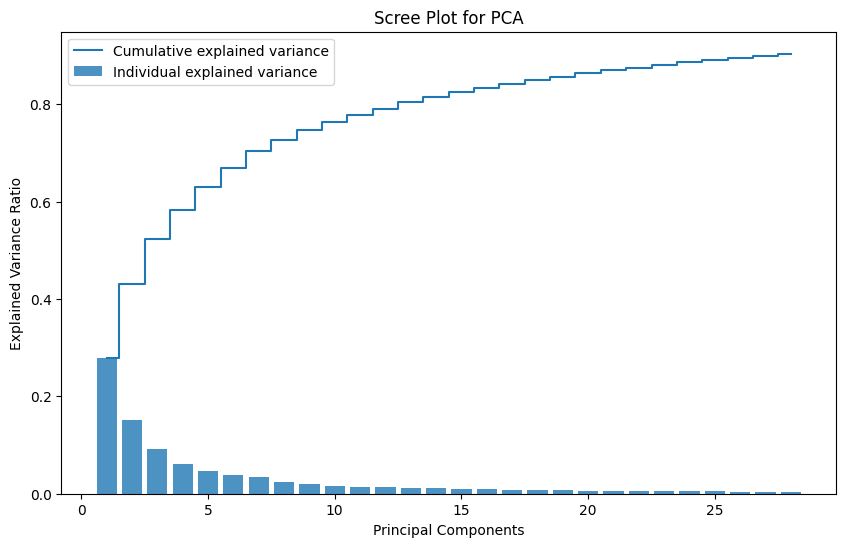

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

columns_to_drop = ['c241', 'overall_risk']
X_c241_new = df1.drop(columns=columns_to_drop)

#Matrics of depenent variable
y_c241 = df1['c241']


X_train_241, X_test_241, y_train_241, y_test_241 = train_test_split(X_c241_new, y_c241, test_size=0.2, random_state=42)

X_train_241_scaled = scaler.fit_transform(X_train_241)
X_test_241_scaled = scaler.transform(X_test_241)

# Apply PCA only on the training data and determine the number of components
desired_variance = 0.9  # Set the desired explained variance
pca = PCA(n_components=desired_variance)
X_train_pca = pca.fit_transform(X_train_241_scaled)
X_test_pca = pca.transform(X_test_241_scaled)

# Get the number of components explaining the desired variance
num_components = pca.n_components_
print(f"Number of components to explain {desired_variance * 100}% of the variance: {num_components}")

explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for PCA')
plt.legend()
plt.show()


# ML using only Principal Components

In [48]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train_pca, y_train_241)

# Make predictions on the training and test sets
y_train_pca_pred_rf = model_rf.predict(X_train_pca)
y_test_pca_pred_rf = model_rf.predict(X_test_pca)

# Evaluate the model
mse_train_pca_rf = mean_squared_error(y_train_241, y_train_pca_pred_rf)
r2_train_pca_rf = r2_score(y_train_241, y_train_pca_pred_rf)

mse_test_pca_rf = mean_squared_error(y_test_241, y_test_pca_pred_rf)
r2_test_pca_rf = r2_score(y_test_241, y_test_pca_pred_rf)

# Print the results
print("Training MSE PCA RF:", mse_train_pca_rf)
print("Training R2 PCA RF:", r2_train_pca_rf)
print("\nTesting MSE PCA RF:", mse_test_pca_rf)
print("Testing R2 PCA RF:", r2_test_pca_rf)

Training MSE PCA RF: 0.08958498931367857
Training R2 PCA RF: 0.8654833745073147

Testing MSE PCA RF: 0.00178802658107922
Testing R2 PCA RF: 0.8590857093117211


# Hence we determine the minimum number of independent features to predict c241 is 28. Using PCA we can ensure that these are orthogonal features that is they are independent of each other, and since we require to only predict and not control it is not essential to determine exactly which features, so loosing explainability with PCA is also not a problem